## Library Project  
#### Presented at [BiLT Europe 2019](https://www.dbeinstitute.org/event/bilt-europe-2019/) in Edinburgh by [Thomas Corrie](http://www.thomascorrie.com/)

***

<img src='../Images/LibraryProjectBanner.png' />

***

# Notebook 2: Analyzing the Results

### Description
This Notebook parses json packing result files for visualization and onward selection for recreating in Dynamo and Revit

<span style="color:red">*Comments in red are notes for future improvements and refinements</span>

# Imports
Libraries for Python

In [1]:
import pandas as pd # For dataframes and manipulation
import numpy as np # For data and arrays
import json # For parsing json files
import random # For generating random numbers
#import time # For sleep
import glob # For finding files
import shutil # For copying files
import os # For files
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
import subprocess # For opening Revit
# Bokeh for plotting
from bokeh.palettes import d3
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, BoxZoomTool, PanTool, WheelZoomTool, ResetTool, TapTool
from bokeh.io import output_notebook
# iPyWidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
# Report Python Version
from platform import python_version
print(python_version())

3.6.8


Optional to suppress warnings from Seaborn / Matplotlib for large plots

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Variables
The folders for the packing results, visualization and Revit files

In [3]:
bookcaseScenarios = '../Json/2_BookcaseScenarios/'

In [4]:
packingResults = '../Json/4_PackingResults/'

In [5]:
visualizationJob = '../Json/5_VisualizationJob/'

In [6]:
revitFiles = '../Revit/Scenarios/'

In [7]:
revitLocation = r'C:\Program Files\Autodesk\Revit 2019\Revit.exe'

# Choose Packing Results
The results to analyse and visualize

In [8]:
bookcaseScenarioFiles = []
for file in glob.glob(bookcaseScenarios + "*.json"):
    bookcaseScenarioFiles.append(os.path.splitext(os.path.basename(file))[0])
chooseDrop = widgets.Dropdown(
    options=list(bookcaseScenarioFiles),
    description='Scenario: ',
    disabled=False,
    layout={'width': 'initial'}
)
chooseItems = [chooseDrop]
widgets.Box(chooseItems)

Box(children=(Dropdown(description='Scenario: ', layout=Layout(width='initial'), options=('191004T230422_Seven…

<span style="color:red">Refine selection methods for date and time based on the file data. At the moment only one scenario can be selected via the dropdown</span>

In [13]:
days = ['_191012T'] # ['_191010T','_191011T'] # day of results

In [14]:
hours = [[0,23]] # [[0,23],[0,23]] # start and end hours (24 hour clock) for each set of results

# Load Results
Finds and loads the packing results and scenario into a dataframe

In [15]:
bookcaseScenario = [chooseDrop.value]
files = glob.glob(packingResults+'.txt')
for scenario in bookcaseScenario:
    for day, hour in zip(days,hours):
        for i in range(hour[0],hour[1]+1):
            files.extend(glob.glob(packingResults+scenario+day+str(i)+'*'))
print('There are ' + str(len(files)) + ' results')

There are 19 results


In [16]:
result = []
scenario = []
variables = []
bookshelves = []
#shelfParams = []
for file in files:
    with open(file, encoding='utf-8-sig') as json_file:
        json_data = json.load(json_file)
        result.append(json_data['result'])
        scenario.append(json_data['scenario'])
        variables.append(json_data['variables'])
        # Shelves
        shelfDict = {}
        for key, value in json_data['bookcases'].items():
            #print('bookcase: ' + key) # bookcase
            for k, v in value['shelves'].items():
                #print(key + '-' + k + ':  ' + str(int(v['use']))) # shelf
                shelfDict[key + '-' + k] = int(v['use'])
        bookshelves.append(shelfDict)
        #shelfParams.append(json_data['shelfParams'])
dfResult = pd.DataFrame(result)
dfScenario = pd.DataFrame(scenario)
dfVariables = pd.DataFrame(variables)
#dfShelfParams = pd.DataFrame(shelfParams)
dfScenario = dfScenario.add_prefix('scenario_')
dfShelves = pd.DataFrame(bookshelves)
dfResults = pd.concat([dfResult, dfScenario, dfVariables], axis=1)

In [17]:
dfShelves.head()

,1-1,1-10,1-11,1-12,1-13,1-14,1-15,1-16,1-17,1-18,...,7-19,7-2,7-20,7-3,7-4,7-5,7-6,7-7,7-8,7-9
0,1,0,0,0,0,0,0,0,1,1,...,1,1,1,1,1,0,0,0,0,0
1,1,1,0,0,0,0,0,1,1,1,...,1,1,1,1,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,1,1,...,1,1,1,1,1,0,1,1,0,0
3,1,0,0,1,0,0,0,0,1,1,...,1,1,1,1,1,0,0,0,0,0
4,1,0,0,0,0,0,1,0,1,1,...,1,1,1,1,1,1,0,0,0,0


## Pickle Dataframe for Machine Learning

In [18]:
dfAll = pd.concat([dfResults, dfShelves], axis=1)
dfAll.to_pickle('../Pickle/training.pkl')

In [21]:
dfResults.select_dtypes(['number']).head(2)

,meanScore,meanScorePlaced,numBooksNotPacked,numBooksPacked,numBooksTotal,numContainers,numDiscrepancy,timePack,scenario_combinations,scenario_numBookcases,...,minimumItems,shelvesAll,shelvesEmpty,shelvesFixed,shelvesFlexible,shelvesFlexibleFalse,shelvesFlexibleTrue,shelvesPercentFlexible,shelvesThreshold,shelvesTrue
0,0.653596,0.663208,12,816,828,69,0,3.989,1.053123e+65,7,...,30,252,13,23,216,164,52,24.1,0.75,88
1,0.639209,0.696402,68,760,828,39,0,4.720,1.053123e+65,7,...,40,252,13,23,216,194,22,10.2,0.90,58
2,0.670791,0.679822,11,817,828,41,0,10.370,1.053123e+65,7,...,55,252,13,23,216,192,24,11.1,0.90,60
3,0.610548,0.657391,59,769,828,59,0,6.676,1.053123e+65,7,...,40,252,13,23,216,174,42,19.4,0.80,78
4,0.644721,0.647851,4,824,828,59,0,12.536,1.053123e+65,7,...,55,252,13,23,216,174,42,19.4,0.80,78
5,0.639437,0.655264,20,808,828,71,0,5.689,1.053123e+65,7,...,35,252,13,23,216,162,54,25.0,0.80,90
6,0.654267,0.691868,45,783,828,31,0,5.874,1.053123e+65,7,...,50,252,13,23,216,202,14,6.5,0.90,50
7,0.653832,0.653832,0,828,828,45,0,10.937,1.053123e+65,7,...,55,252,13,23,216,188,28,13.0,0.85,64
8,0.674484,0.676936,3,825,828,52,0,3.974,1.053123e+65,7,...,35,252,13,23,216,181,35,16.2,0.85,71
9,0.624220,0.714874,105,723,828,38,0,2.693,1.053123e+65,7,...,35,252,13,23,216,195,21,9.7,0.90,57


In [22]:
colsToDrop = ['numBooksTotal','shelvesAll','shelvesEmpty','shelvesFixed','shelvesFlexible','shelvesFlexibleFalse','shelvesFlexibleTrue','shelvesPercentFlexible','shelvesTrue','scenario_combinations','scenario_numBookcases','infillMaxHeight','containerStrategy','infillVolumePriority','containerOrientation','numDiscrepancy','bookAlignment']
# colsToDrop = ['numBooksTotal','shelvesAll','shelvesEmpty','shelvesFixed','shelvesFlexible','shelvesFlexibleTrue','shelvesFlexibleFalse','shelvesPercentFlexible','shelvesTrue','combinations','numBookcases','heightAboveBookcase','includeAboveBookcase']

# Correlation Heatmap

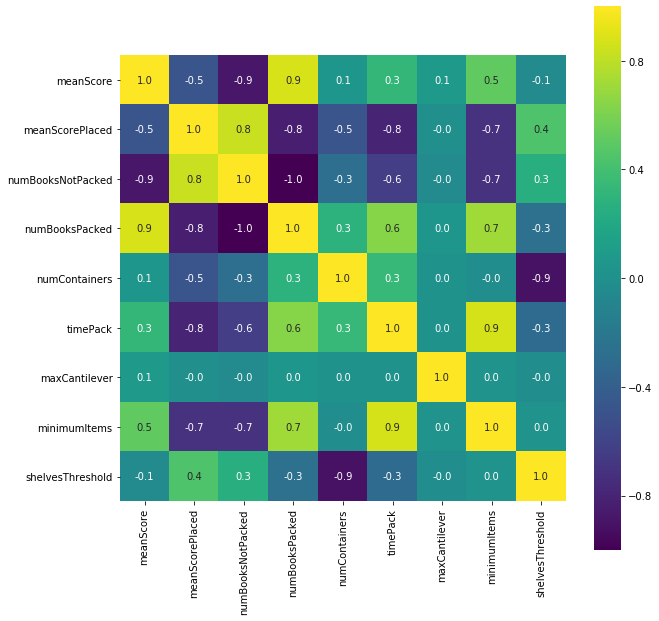

In [23]:
fig, ax = plt.subplots(figsize=(10,10))   
ax = sns.heatmap(dfResults.select_dtypes(['number']).drop(colsToDrop, axis=1).corr(), 
            cmap='viridis', 
            annot=True, annot_kws={'size':10}, 
            fmt=".1f",
            square=True);

# PairPlot

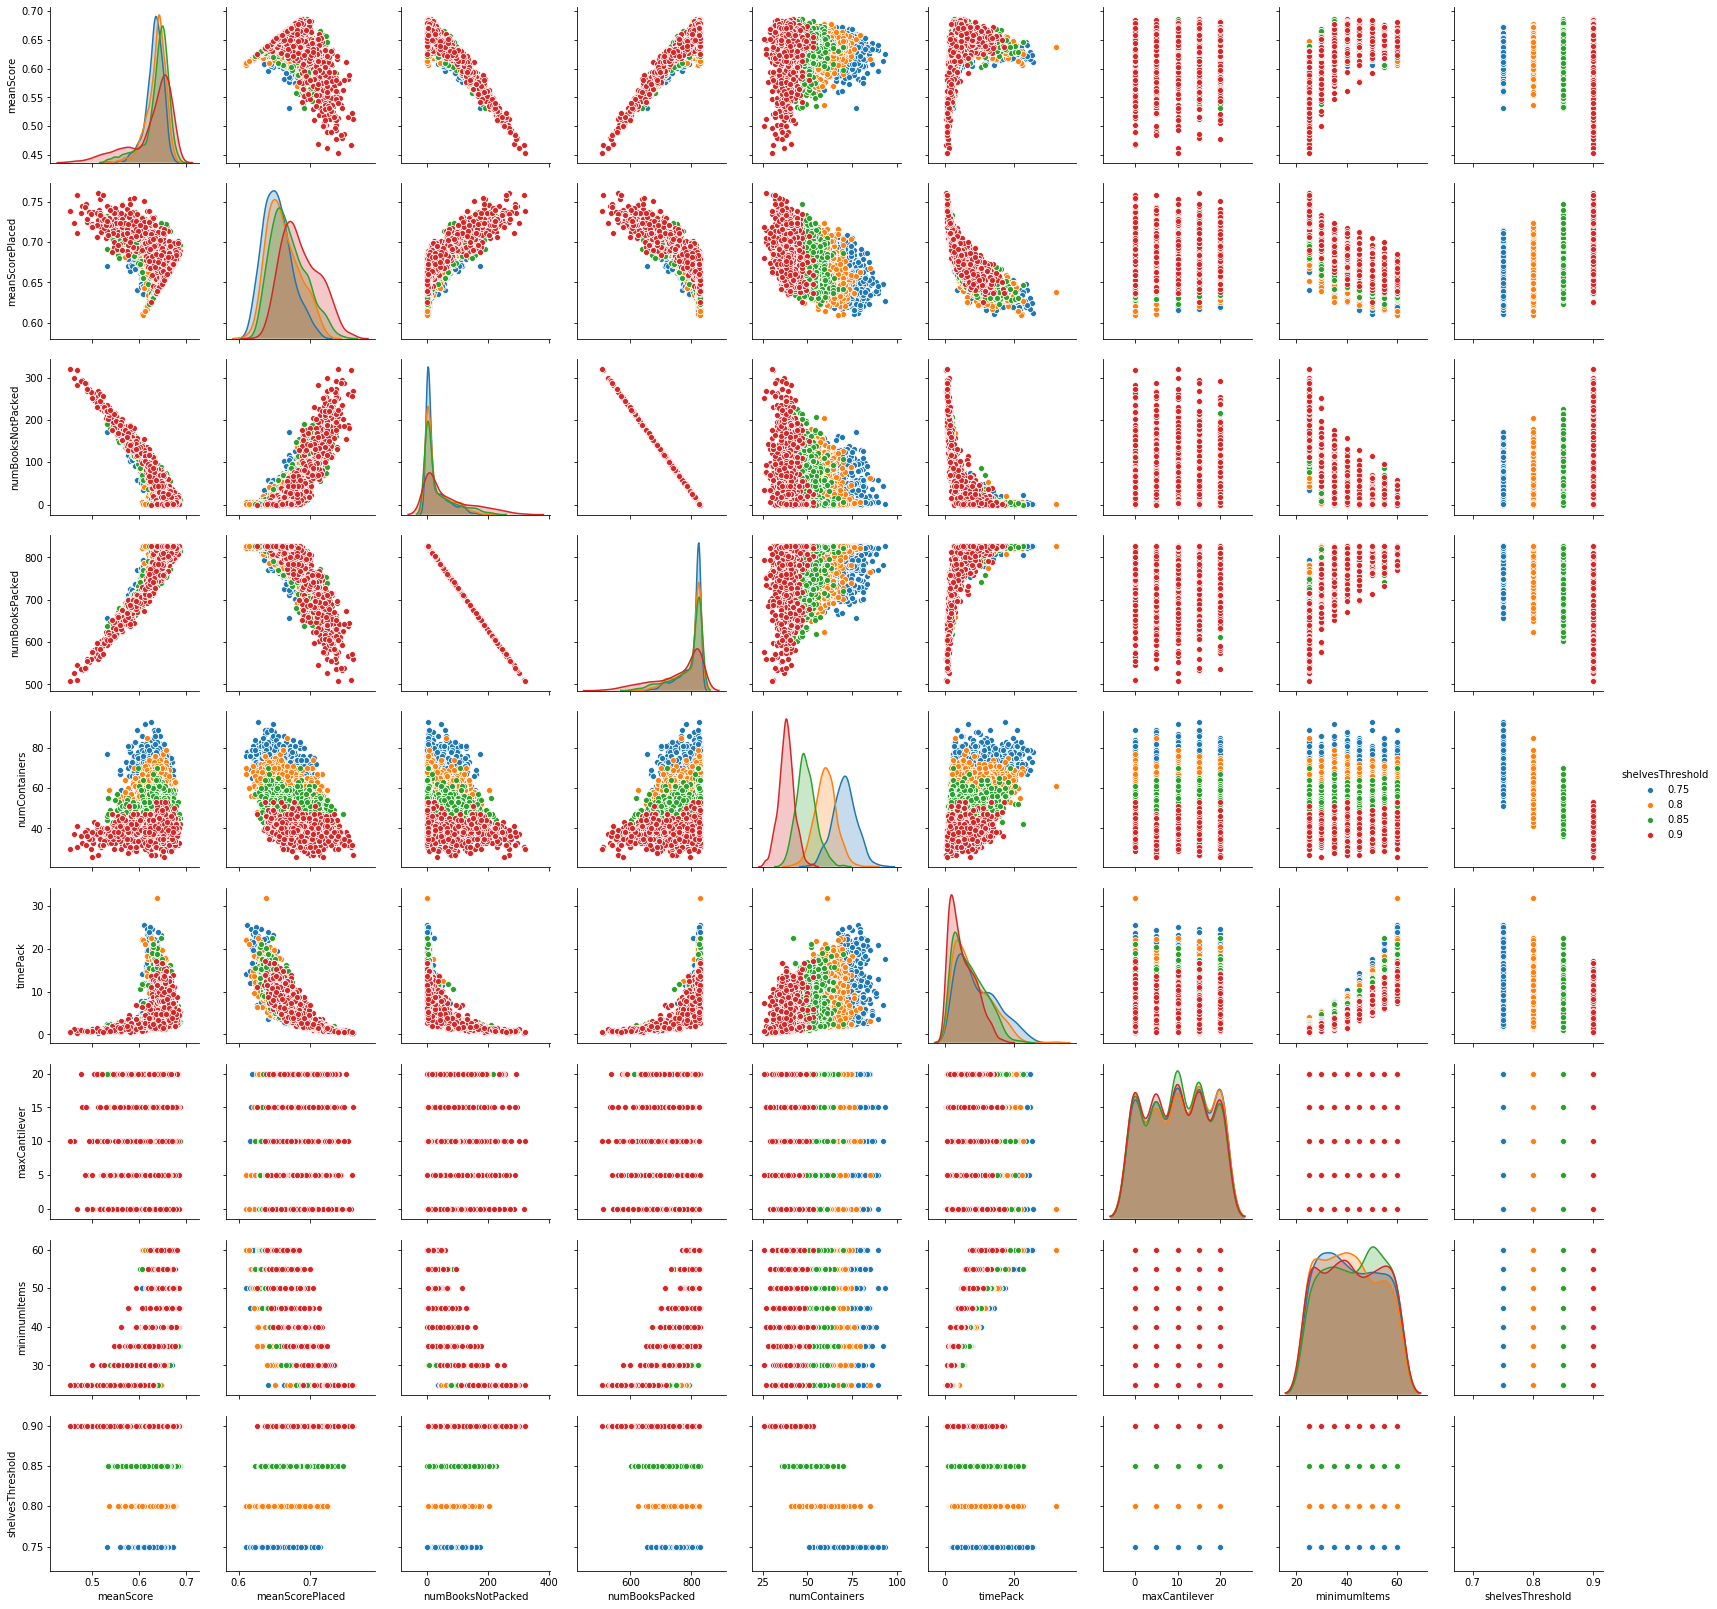

In [24]:
pairplotThreshold = sns.pairplot(dfResults.select_dtypes(['number']).drop(colsToDrop, axis=1), hue='shelvesThreshold')
# pairplotThreshold.savefig("../Resources/Graphs/BulkAnalysis_Pairplot_Threshold.png");

# Scatterplots
Use ipywidgets to create dropdowns for choosing data to plot

In [25]:
xDrop = widgets.Dropdown(
    options=list(dfResults.columns),
    description='X Axis:',
    disabled=False,
    value='numBooksPacked'
)
yDrop = widgets.Dropdown(
    options=list(dfResults.columns),
    description='Y Axis:',
    disabled=False,
    value='meanScore'
)
Colour = widgets.Dropdown(
    options=list(dfResults.columns),
    description='Colour:',
    disabled=False,
    value='shelvesThreshold'
)

items = [xDrop, yDrop, Colour]
widgets.Box(items)

Box(children=(Dropdown(description='X Axis:', index=9, options=('computer', 'datetime', 'description', 'dynamo…

Scatterplot using Matplotlib

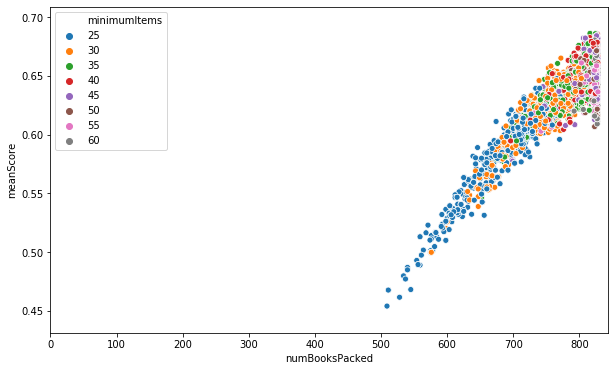

In [47]:
x = xDrop.value
y = yDrop.value
field = Colour.value # shelvesThreshold' #minimumItems
bins = len(dfResults[field].unique())
#dfResults[field].unique(), bins, sns.color_palette('tab10', n_colors=bins)
scatter = plt.figure(figsize=(10, 6))
s = sns.scatterplot(x=x, y=y, hue=field, marker='o', data=dfResults, palette=sns.color_palette('tab10', bins));
#s.set(ylim=(0, 1))
s.set(xlim=(0, None));
# scatter.savefig("../Resources/Graphs/BulkAnalysis_Scatter_"+x+'-'+y+'-'+field+".png")

Add colours to dataframe for Bokeh

In [48]:
thresholds = []
for t in dfResults[field]:
    thresholds.append(str(t))
thresholdvals = list(np.unique(thresholds))
length = len(thresholdvals)
if length < 3:
    length = 3
colorsc = d3['Category10'][length]
colors = {}
for v, c in zip(sorted(set(dfResults[field])), colorsc):
    colors[v] = c
colors
dfResults['col'] = dfResults[field].apply(lambda x : colors[x])
output_notebook()

source = ColumnDataSource(
        data=dict(
            x=dfResults[x],
            y=dfResults[y],
            cols=dfResults['col'],
            index=dfResults.index,
            date=dfResults['datetime'],
            score=dfResults['meanScore'],
            desc=dfResults['description'],
            nbp=dfResults['numBooksPacked'],
            nbt=dfResults['numBooksTotal'],
            thresh=dfResults['shelvesThreshold'],
            mini=dfResults['minimumItems'],
            shelvesFlex=dfResults['shelvesFlexible'],
            shelvesFlexTrue=dfResults['shelvesFlexibleTrue'],
            maxCantilever=dfResults['maxCantilever'],
            containerOrientation=dfResults['containerOrientation'],
            containerStrategy=dfResults['containerStrategy'],
            infillVolumePriority=dfResults['infillVolumePriority']
        )
    )

hover = HoverTool(
        tooltips=[
            #("(x,y)", "($x, $y)"),
            ("index", "@index"),
            ("id", "@date"),
            ("desc", "@desc"),
            ("Books Packed", "@nbp out of @nbt"),
            ("Mean Score", "@score"),
            ("Shelves Threshold", "@thresh"),
            ("Flexible Shelves Used", "@shelvesFlexTrue out of @shelvesFlex"),
            ("Minimum Items", "@mini"),
            ("Container Strategy", "@containerStrategy"),
            ("Container Orienatation", "@containerOrientation"),
            ("Infill Volume Priority", "@infillVolumePriority"),
            ("Maximum Cantilever", "@maxCantilever")
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, WheelZoomTool(), BoxZoomTool(), PanTool(), ResetTool()],
           active_scroll = 'auto', title=xDrop.value + " v " + yDrop.value + " coloured by " + field, x_axis_label=xDrop.value, y_axis_label=yDrop.value)
p.circle('x', 'y', size=5, source=source, color='cols')
show(p)

Loading BokehJS ...

# Prepare for Visualizing in Revit
Select Index of Result to Visualize

In [63]:
indexNum = 3165

Show result information

In [64]:
dfResults.iloc[indexNum].head(10)

computer                                   HA-L1918
datetime                              191011T231936
description                           Seven Shelves
dynamoFilename       FurtherLibrary_2_ImportAndPack
dynamoLong                               2.4.0.6186
dynamoShort                                   2.4.0
meanScore                                   0.45403
meanScorePlaced                            0.738579
numBooksNotPacked                               319
numBooksPacked                                  509
Name: 3165, dtype: object

Copy results json and Revit scenario to visualization job folder

In [65]:
packName = dfResults.iloc[indexNum]['packName']
fileToCopy = glob.glob(packingResults + packName + '.json')[0]
fileToWrite = visualizationJob + 'visualizationJob.json'
fileToCopyRevit = revitFiles + dfResults.iloc[indexNum]['scenario_revitFilename'] + '.rvt'
fileToWriteRevit = visualizationJob + 'scenarioRevit.rvt'
shutil.copyfile(fileToCopy,fileToWrite);
shutil.copyfile(fileToCopyRevit,fileToWriteRevit);

Open Revit with underlying rvt scenario file using subprocess

In [66]:
fileToOpen = fileToWriteRevit
# Use subprocess.Popen rather than subprocess.run as run waits for a return from the program
subprocess.Popen([revitLocation, fileToOpen]);